In [1]:
import nbsetup
import pymc3 as pm
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt
from models.equations import velocity, combined_force, null_gravity
from models.sparc.result import Result

In [3]:
import theano.tensor as tt
https://stackoverflow.com/questions/70839312/module-numpy-distutils-config-has-no-attribute-blas-opt-info

SyntaxError: invalid syntax (383180049.py, line 2)

In [6]:
import pymc3 as pm
pm.__version__

AttributeError: partially initialized module 'theano' has no attribute 'graph' (most likely due to a circular import)

In [2]:
default = Result()

In [ ]:
df = default.datasets()['Quality Thresholded']

In [ ]:
coords = {
    "Galaxy": df.Galaxy.unique(),
    "Observation": df.Vobs.index
}

# using the ref values as the initial reference points
reference = df.groupby('Galaxy').mean()[['Inc', 'e_Inc', 'D', 'e_D']]#+['Ydisk','e_Ydisk','Ybul','e_Ybul']

# for g param
if 'gidx' not in df.columns:
    uniqs = df.ID.unique()
    indx = pd.DataFrame({'Galaxy':uniqs, 'gidx':np.arange(len(uniqs))})
    df = df.join(indx.set_index('Galaxy'), on='Galaxy')

with pm.Model(coords=coords) as galaxy_model:
    
    # Universal priors
    gamma = pm.Uniform('gamma', 0, 200)
    alpha = pm.Uniform('alpha', 0, 1)
    
    # Galaxy priors
    # As per method of RAR papera
    DegreesNormal = pm.Bound(pm.Normal, lower=0.0, upper=90.0)
    inc = DegreesNormal('Inc', mu=reference.Inc, sigma=reference.e_Inc, dims='Galaxy')
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    dist = PositiveNormal('D', mu=reference.D, sigma=reference.e_D, dims='Galaxy')
    #Ydisk = PositiveNormal('Ydisk', mu=reference.Ydisk, sigma=reference.e_Ydisk, dims='Galaxy')
    #Ybul = PositiveNormal('Ybul', mu=reference.Ybul, sigma=reference.e_Ybul, dims='Galaxy')
    #if use_tau: tau = pm.Exponential('tau', 1)
    tau = 0

    # Data
    force = pm.Data("force", df.Fnewton, dims="Observation")
    radius = pm.Data("radius", df.R, dims="Observation")
    nulled = pm.Data("nulled", df.Fnulled, dims="Observation")
    sparc_d = pm.Data("sparc_distance", df.D, dims="Observation")
    sparc_inc = pm.Data("sparc_inc", df.Inc, dims="Observation")
    g = pm.Data("g", df.gidx, dims="Observation")
    
    # Prediction model
    # adjust for nulled field
    ftd = null_gravity(force, nulled, gamma, alpha)
    # adjust r for distance when calc Velocity
    vtd = velocity(radius*dist[g]/sparc_d[g], ftd)
    # adjust the predicition for inclination of Vobs
    Vpred = vtd*np.sin(inc[g]*np.pi/180)/np.sin(sparc_inc[g]*np.pi/180)
    
    # Define likelihood
    obs = pm.Normal("obs", mu=Vpred, sigma=df.e_Vobs, observed=df.Vobs, dims="Observation")

In [174]:
with galaxy_model:
    start = pm.find_MAP()
    print(start['gamma'], start['alpha'])
    trace = pm.sample(tune=1000, draws=500, cores=2, return_inferencedata=True, target_accept=0.9, start=start)


94.59015055428985 0.25253932477916075


/var/folders/xp/fglbvhls6671ywk1lqtr308w0000gn/T/ipykernel_61772/1952488712.py:4: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(tune=1000, draws=500, cores=2, return_inferencedata=True, target_accept=0.9, start=start)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [D, Inc, alpha, gamma]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 425 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


array([<AxesSubplot:title={'center':'gamma'}>,
       <AxesSubplot:title={'center':'alpha'}>], dtype=object)

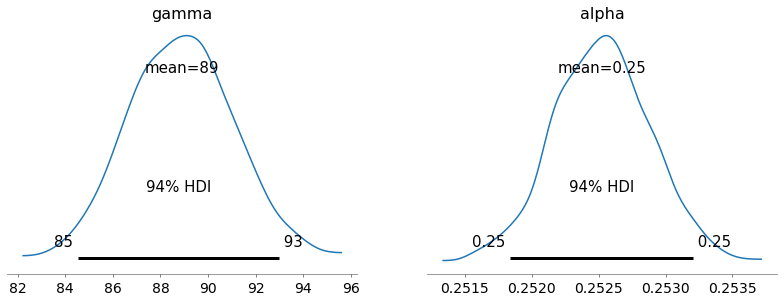

In [176]:
az.plot_posterior(trace, var_names=['gamma', 'alpha'])

In [187]:
results = az.summary(trace, fmt='long')

In [191]:
results

,galaxy,gamma,alpha,Inc,D
mean,CamB,88.89,0.253,14.492,3.002
mean,DDO064,88.89,0.253,58.462,1.165
mean,DDO154,88.89,0.253,35.852,3.223
mean,DDO161,88.89,0.253,67.078,0.559
mean,DDO168,88.89,0.253,24.871,4.096
...,...,...,...,...,...
r_hat,UGC11914,1.02,1.008,1.003,1.003
r_hat,UGC12632,1.02,1.008,1.004,1.003
r_hat,UGC12732,1.02,1.008,1.000,1.000
r_hat,UGCA442,1.02,1.008,1.007,1.006


In [200]:
source = 'Simple model'
adjustments = []
for galaxy, gdf in results.groupby('galaxy'):
    data = {'Galaxy': galaxy, 'Source': source}
    for param in ['Inc', 'D']:#+['Ydisk', 'Ybul']+['Tau']
        data[param] = gdf[param]['mean']
        data['e_%s' % param] = gdf[param]['sd']
    data['Ydisk'] = 0.5
    data['Ybul'] = 0.7
    adjustments.append(data)
adjustments = pd.DataFrame(adjustments)

In [201]:
first_mcmc = Result(adjustments=adjustments)

NameError: name 'inc_adjust' is not defined

In [195]:
# once you've done the adjustments via inputting it into a Results object
# this will update the mass ratios, R etc for us
# so can safely use here
T_force = null_gravity(df['Fnewton'], df['Fnulled'], gamma=, alpha=) # might need to include tau here
df['Tgbar'] = T_force
df['log_Tgbar'] = np.log10(T_force)
df['Tbar'] = velocity(df['R'], T_force)


,R,Vobs,e_Vobs,Vgas,Vdisk,Vbul,SBgas,SBdisk,SBbul,ID,...,Fnewton,Fabs,Fnulled,Wbar,Vgbar,log_Vgbar,Wgbar,log_Wgbar,VWdiff,gidx
0,0.16,1.99,1.50,1.53,3.95,0.0,4.39,33.32,0.0,CamB,...,40.851351,2037.699759,1996.848408,2.556602,63.388438,1.802010,40.851351,1.611206,0.036406,0
1,0.41,4.84,1.50,3.59,9.97,0.0,3.81,26.13,0.0,CamB,...,171.860737,1666.636318,1494.775581,8.394218,152.655000,2.183711,171.860737,2.235177,0.002649,0
2,0.57,6.79,1.50,4.79,12.42,0.0,3.35,17.44,0.0,CamB,...,191.146829,1333.537909,1142.391079,10.438089,175.565439,2.244439,191.146829,2.281367,0.001364,0
3,0.73,8.87,1.50,5.79,14.50,0.0,2.79,13.62,0.0,CamB,...,207.414036,1068.454414,861.040378,12.304968,189.930274,2.278594,207.414036,2.316838,0.001463,0
4,0.90,10.90,1.50,6.72,15.72,0.0,2.21,10.58,0.0,CamB,...,205.098740,839.217895,634.119155,13.586349,187.464000,2.272918,205.098740,2.311963,0.001525,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,2.33,36.10,5.47,13.59,5.43,0.0,0.63,0.21,0.0,UGCA444,...,95.551327,140.900437,45.349110,14.920945,85.592511,1.932436,95.551327,1.980237,0.002285,127
3323,2.40,37.20,5.39,13.27,5.47,0.0,0.00,0.19,0.0,UGCA444,...,87.109726,97.663120,10.553394,14.459023,79.605563,1.900943,87.109726,1.940067,0.001531,127
3324,2.48,37.60,7.10,12.69,5.54,0.0,0.00,0.17,0.0,UGCA444,...,72.915243,82.691661,9.776418,13.447297,71.121734,1.852002,72.915243,1.862818,0.000117,127
3325,2.55,35.60,4.73,12.30,5.48,0.0,0.00,0.00,0.0,UGCA444,...,65.875847,75.227004,9.351157,12.960841,65.217725,1.814366,65.875847,1.818726,0.000019,127


In [185]:
from references.sparc import adjustment_df
adjs = adjustment_df()

ImportError: cannot import name 'adjustment_df' from 'references.sparc' (/Users/timjdavey/Projects/darkness/relativity/notebooks/../references/sparc.py)